# Summarize Text

[Summarize Text - Stuff + Map-Reduce](https://python.langchain.com/docs/tutorials/summarization/) 、 [Summarize Text - iterative refinement](https://python.langchain.com/docs/how_to/summarize_refine/)

总结或合并文档的方式：
- **Stuff**: 把所有文档合并到 prompt 中
- **Map-reduce** : 通常用于大的文档。它将文档分为几部分，分别 summarize 各个部分，再将各个部分的 summarization 整合到 prompt 让模型 summarize
- **iterative refinement** : Map-reduce 方法可能会丢失上下文信息。而 refine 方法的原理是，首先将文档拆分为若干更小的文档，然后总结第一份文档，根据下一个文档优化或更新结果，重复上述操作，直至完成

其中，当子文档的理解不依赖于上下文时， **Map-reduce** 是非常高效的方法。如总结由许多短文档组成的语料库<br>
相反，当总结一部小说或具有固定顺序的文章时，**iterative refinement** 方法更加高效

## Setup

In [1]:
import os
from langchain.chat_models import init_chat_model

os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'
os.environ.get("GOOGLE_API_KEY")

llm = init_chat_model('gemini-2.5-flash', model_provider='google-genai')

In [3]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

## Stuff: summarize in a single LLM call

> 这里我按照官方文档的代码跑报错了，改成了如下版本

In [20]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_template(
    "Write a concise summary of the following:\\n\\n{context}"
)

# Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)

# Invoke chain
result = chain.invoke({"context": docs})
print(result)

LLM-powered autonomous agents utilize large language models as their core controller, augmented by three key components:

1.  **Planning:** Agents break down complex tasks into subgoals (e.g., Chain of Thought) and employ self-reflection mechanisms (e.g., ReAct, Reflexion) to learn from past actions, refine plans, and improve performance.
2.  **Memory:** This extends beyond the LLM's finite context window. Short-term memory is akin to in-context learning, while long-term memory leverages external vector stores and Maximum Inner Product Search (MIPS) for efficient retrieval of vast information.
3.  **Tool Use:** Agents can interact with external APIs and specialized modules (e.g., ChatGPT Plugins, HuggingGPT, ChemCrow) to expand their capabilities, facilitating tasks like scientific discovery or simulating human behavior.

Despite promising proof-of-concept demos (e.g., AutoGPT, GPT-Engineer), significant challenges remain, including finite context length, difficulties in long-term plan

## Map-Reduce: 并行化处理长文本摘要

Map-reduce 的核心思想：
1. **映射 Map** : 将每个子文档独立输入 LLM 生成局部摘要。这一步天然适合并行处理，我们可以同时向多个 LLM 实例发送请求，大幅提升处理效率。
2. **规约 Reduce** : 将所有局部摘要合并为一个全局摘要。这里需要注意，如果局部摘要的总长度仍超过模型上下文窗口，需要递归执行 “分割 - 摘要 - 合并” 的过程，直到结果符合要求。

### (1) 核心提示词模板

包括 Map 阶段的提示词和 Reduce 阶段的提示词

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

# map_prompt = ChatPromptTemplate.from_messages(  # Gemini不接受这种格式，可能是因为没有HumanMessage
#     [('system', 'Write a concise summary of the following:\\n\\n{context}')]
# )
map_prompt = ChatPromptTemplate.from_messages(  # 严格来说，这种方式是不行的
    SystemMessage('Write a concise summary of the following:\\n\\n{context}')
)

# 推荐改成以下方式：
# map_prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are a careful summarizer."),
#     ("human", "Write a concise summary of the following:\n\n{context}")
# ])

In [37]:
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

### (2) 文本分割

文本分割是处理超长文本的前提

In [31]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(len(split_docs))

# print(type(split_docs[0]))  # <class 'langchain_core.documents.base.Document'>

Created a chunk of size 1003, which is longer than the specified 1000


13


### (3) 构建状态图：定义工作流逻辑

In [42]:
import operator
from typing import Annotated, List, Literal, TypedDict
from langchain.chains.combine_documents.reduce import(
    acollapse_docs,
    split_list_of_docs
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000

def length_funcation(documents: List[Document]) -> int:
    """get number of tokens of input contents"""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


class OverallState(TypedDict):
    """
    contents: 原始子文档内容列表
    summaries: 所有局部摘要
    collapsed_summaries: 中间合并结果
    final_summary: 最终的全局摘要
    """
    contents: List[str]
    summaries: Annotated[list, operator.add]  # operator.add 是为了把每次的summary整合到一起
    collapsed_summaries: List[Document]
    final_summary: str


class SummaryState(TypedDict):  # 用于生成summary的文本的state
    content: str


# Node - 生成局部摘要
async def generate_summary(state: SummaryState):
    """generate partial summary"""
    prompt = map_prompt.invoke(state['content'])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}


# 从状态里取出所有文本片段，把它们逐一打包成任务，
# 交给 'generate_summary' 节点去处理，形成 Map 阶段的并行摘要请求。
def map_summaries(state: OverallState):
    return [
        Send('generate_summary', {'content': content}) for content in state['contents']
    ]


# Node - 初始化collapsed_summries为所有局部摘要的合集
def collect_summaries(state: OverallState):
    return {
        'collapsed_summaries': [Document(summary) for summary in state['summaries']]
    }


# 规约步骤——对输入文本进行摘要
async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content


# Node - 对超过token_max的文本再次进行 “分割-->摘要-->合并”
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state['collapsed_summaries'], length_func=length_funcation, token_max=token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))
    return {'collapsed_summaries': results}


# 判断当前文本collapsed_summaries是否需要进一步分割
def should_collapse(
        state: OverallState
) -> Literal['collapse_summaries', 'generate_final_summary']:
    num_tokens = length_funcation(state['collapsed_summaries'])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return 'generate_final_summary'

# Node - 生成最后的文本摘要
async def generate_final_summary(state: OverallState):
    response = await _reduce(state['collapsed_summaries'])
    return {"final_summary": response}

# 构建图
# nodes
graph = StateGraph(OverallState)
graph.add_node('generate_summary', generate_summary)
graph.add_node('collect_summaries', collect_summaries)
graph.add_node('collapse_summaries', collapse_summaries)
graph.add_node('generate_final_summary', generate_final_summary)

# edges
graph.add_conditional_edges(START, map_summaries, ['generate_summary'])
graph.add_edge('generate_summary', 'collect_summaries')
graph.add_conditional_edges('collect_summaries', should_collapse)
graph.add_conditional_edges('collapse_summaries', should_collapse)
graph.add_edge('generate_final_summary', END)

app = graph.compile()

C:\Users\86136\AppData\Local\Temp\ipykernel_3816\840984269.py:8: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


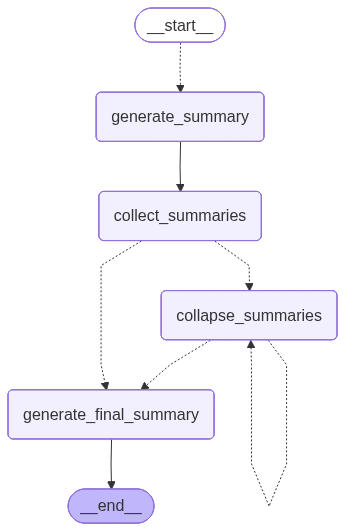

In [34]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [43]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 44.672850242s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 44
}
].


['generate_summary']


Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 42.384708234s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 42
}
].


['generate_summary']
['generate_summary']


Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 8.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 38.192319551s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 38
}
].


['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']


Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 16.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 29.898595567s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 29
}
].


['generate_summary']
['generate_summary']


Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 32.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 13.590891222s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 13
}
].


['generate_summary']
['collect_summaries']
['collapse_summaries']
['collapse_summaries']
['generate_final_summary']


In [44]:
print(step)

{'generate_final_summary': {'final_summary': 'The documents collectively describe the rapid evolution of LLM-powered autonomous agents, leveraging large language models as central "brains" for general problem-solving. A dominant theme is the **augmentation of LLMs with external tools and specialized modules**, enabling them to interact with APIs, execute code, and access external data to overcome inherent limitations.\n\nThese agents incorporate advanced cognitive architectures, featuring sophisticated **planning and reasoning mechanisms** (such as iterative task breakdown, multi-path reasoning, Chain of Thought, Tree of Thoughts, and reasoning-action loops like ReAct and Reflexion), robust **memory systems** (including short-term in-context memory and long-term vector stores), and strong **self-reflection and self-improvement capabilities** (learning from feedback and past trajectories like Chain of Hindsight).\n\nThis enables a wide range of applications, including autonomous **code 

## iterative refinement

为了方便，这里不用上述的docs了

> 在本方法中，明明它的特点是顺序执行，官方文档仍然使用异步的方式执行，（猜测）原因如下: <br>
> 1. 保持接口的一致性。在单纯的 `iterative refinement` 方法里，异步虽然看似没有发挥优势，但并不会阻塞事件循环。写法统一，开发者不用切换思维
> 2. 可组合性：在更大的工作流程中，refine 可能只是其中一环，外层可能有并行任务。保持异步接口能让它无缝嵌入。
> 3. 在多用户环境中，多个请求可以并发执行，即使每个请求内部是顺序的

In [49]:
documents = [
    Document(page_content='apples are red', metadata={'title': 'apple_book'}),
    Document(page_content="blueberries are blue", metadata={'title': 'blueberry_book'}),
    Document(page_content="bananas are  yellow", metadata={'title': 'banana_book'}),
]

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage


summary_prompt = ChatPromptTemplate([
    ('human', 'Write a concise summary of the following: {context}')
])


refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

class State(TypedDict):
    contents: List[str]
    index: int
    summary: str

async def generate_initial_summary(state: State, config: RunnableConfig):
    prompt = summary_prompt.invoke(state['contents'][0])
    summary = await llm.ainvoke(prompt)
    return {'summary': summary, 'index': 1}

async def refine_summary(state: State, config: RunnableConfig):
    content = state['contents'][state['index']]
    prompt = refine_prompt.invoke({'existing_answer': state['summary'], 'context': content})
    summary = await llm.ainvoke(prompt)
    return {'summary': summary, 'index': state['index']+1}

def should_refine(state: State):
    if state['index'] >= len(state['contents']):
        return END
    else:
        return 'refine_summary'
    

graph = StateGraph(State)
graph.add_node('generate_initial_summary', generate_initial_summary)
graph.add_node('refine_summary', refine_summary)

graph.add_edge(START, 'generate_initial_summary')
graph.add_conditional_edges('generate_initial_summary', should_refine)
graph.add_conditional_edges('refine_summary', should_refine)

app = graph.compile()

In [ ]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [95]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in documents]},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary.content)

Apples are red.
Apples are red and blueberries are blue.
Apples are red, blueberries are blue, and bananas are yellow.


## 实际应用

- 除了 `Stuff` 、 `Map-Reduce` 、 `iterative refinement` 等方法外，一些  [repo](https://github.com/firecrawl/QA_clustering?tab=readme-ov-file) 还提出了引入聚类的方法，如下图<br>


![Summarize Text](./img/253349764-2f6d4408-2eb3-49b1-92c6-5b2c4a2c7260.png)
